In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/')

Mounted at /content/drive


In [3]:
import Data_generator_multiple as dg
import Portfolio_info as poi
import datetime
import pandas as pd
from datetime import date
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.cuda.amp import autocast, GradScaler
from torch import optim
import math, random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [34]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# Set model parameters
seed = 33
num_stocks = 2
total_path = 3000
n_partition = 1
npaths = int(total_path/n_partition)
seq_length = 240
T=10
s0=np.array([1,1])
mu = np.array([0.12, 0.12])
#mu = np.array([0.0362, 0.0036])
k = 0.15
#cov = np.array([[0.0225, 0.00132],[0.00132, 0.0016]])
cov = np.array([[0.4-k, k],[k, 0.4-k]])
trade_cost = [0.01,0.01]
utility_gamma = 2.000

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 80
learning_rate = 0.02

In [5]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# Set model parameters
seed = 36
num_stocks = 3
total_path = 30000
n_partition = 1
npaths = int(total_path/n_partition)
seq_length = 80
T=5
s0=np.array([1,1,1])
mu = np.array([0.12, 0.12, 0.12])
cov = 0.032*np.ones([3,3])
np.fill_diagonal(cov,0.16)
trade_cost = [0.01,0.01,0.01]
utility_gamma = 10.000

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 100
learning_rate = 0.005

In [6]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# Set model parameters
seed = 36
num_stocks = 10
total_path = 30000
n_partition = 1
npaths = int(total_path/n_partition)
seq_length = 70
T=10
s0=np.array([1,1,1,1,1,1,1,1,1,1])
mu = 0.13*s0
cov = 0.016*np.ones([num_stocks,num_stocks])
np.fill_diagonal(cov,0.16)
trade_cost = [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
utility_gamma = 2.000

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 80
learning_rate = 0.03

In [ ]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# Set model parameters
seed = 36
num_stocks = 30
total_path = 20000
n_partition = 1
npaths = int(total_path/n_partition)
seq_length = 30
T=1
s0=np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
mu = 0.12*s0
cov = 0.016*np.ones([num_stocks,num_stocks])
np.fill_diagonal(cov,0.16)
trade_cost = [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
utility_gamma = 2.000

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 120
learning_rate = 0.02

In [ ]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# info of the specific portfolio ETF
manage_fee = 0.005
etf = 'EDOW'
tickers = tickers = ["INTC", "MSFT", "CRM", "AMGN", "UNH", "AAPL", "PG", "JNJ", "VZ", "WMT", "WBA", "MCD",
                     "CSCO", "DIS", "CVX", "KO", "IBM", "V", "MRK", "BA", "NKE", "DOW", "HD", "MMM", "GS",
                     "HON", "AXP", "TRV", "JPM", "CAT"]
#set up dates
start = '2020-08-31'
end = '2023-03-31'
start_day,end_day = str(start).split('-'),str(end).split('-')
# create portfolio
utility_gamma = 10.000
my_portfolio = poi.EqualWeight(etf, tickers, utility_gamma,manage_fee, start , end)
# Set model parameters
T = 0.4
seed = 36
num_stocks = len(tickers)
total_path = 30000
n_partition = 10
npaths = int(total_path/n_partition)
seq_length = int(T*256)
s0=np.array([1]*num_stocks)

mu = np.array(my_portfolio.mu().T.tolist()[0])
cov = my_portfolio.covariance()
trade_cost = [0.01]*num_stocks


# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 50
learning_rate = 0.04

In [ ]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# info of the specific portfolio ETF
manage_fee = 0.0027
etf = 'EQL'
tickers = ["XLE", "XLF", "XLP", "XLV", "XLB", "XLK", "XLY", "XLI", "XLU", "XLRE", "XLC"]
#tickers = ["XLE", "XLF", "XLP", "XLV", "XLB", "XLK", "XLY", "XLI", "XLU"]
#set up dates
#start = '2019-02-28'
#end = '2023-05-31'
start = '1998-08-01'
end = '2023-06-01'
start_day,end_day = str(start).split('-'),str(end).split('-')
# create portfolio
utility_gamma = 1.5
my_portfolio = poi.EqualWeight(etf, tickers, utility_gamma,manage_fee, start , end)
# Set model parameters
T = 8
seed = 36
num_stocks = len(tickers)
total_path = 20000
n_partition = 1
npaths = int(total_path/n_partition)
seq_length = int(T*12)
s0=np.array([1]*num_stocks)

mu = np.array(my_portfolio.mu().T.tolist()[0])
cov = my_portfolio.covariance()
trade_cost = [0.01]*num_stocks


# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 90
learning_rate = 0.01

In [ ]:
# adjustment of covariance matrix and relative mu to keep the covariance matrix positive definite
# uses only when the covariance is not postive definite
def return_matrix_or_alternative(matrix, n):
    try:
        # Attempt to perform a Cholesky decomposition
        np.linalg.cholesky(matrix)
        # If successful, return the matrix itself
        return matrix
    except np.linalg.LinAlgError:
        # If the decomposition fails, return the specified alternative
        return (matrix*0.995+np.identity(n)*0.005)

cov = return_matrix_or_alternative(cov, num_stocks)
mu = (utility_gamma*np.matmul(cov,my_portfolio.strategy()))
mu = np.array(mu.T.tolist()[0])

In [35]:
# set up the trading costs
all_cost = np.ones([num_stocks,seq_length-1,total_path])
for i in range(num_stocks):
  all_cost[i,:,:] = trade_cost[i]

# calculate rho: Notice the single is used only for plotting a 2 asset situation
if (num_stocks==2):
    rho = np.round(cov[0,1]/(np.sqrt(cov[0,0]*cov[1,1])),3)

In [36]:
# To determine optimal trading frequency, based on Johannes Muhle-Karbe's paper, higher dimension waited to be verified
# step 1: Calculting the Markowitz optimal
Markowitz_opt = np.matmul(np.linalg.inv(cov),mu)/utility_gamma
Markowitz_opt_tensor =  torch.tensor(Markowitz_opt,dtype = torch.float).to(device)
# Create a stock simulation with prices, returns
stock = dg.ManyStocks(seed,num_stocks,mu.T,s0,cov,total_path,seq_length-1,T)
returns = torch.tensor(stock.Returns(),dtype=torch.float).to(device)
# Create a default strategy as initial input, better use the optimal strategy without cost
strategy = (torch.tensor(Markowitz_opt,dtype=torch.float).view(num_stocks,1,1)*torch.ones((num_stocks,seq_length,total_path),dtype=torch.float)).to(device)
#strategy = 1/11*torch.ones((num_stocks,seq_length,total_path),dtype=torch.float).to(device)
# Create a trading cost
cost =  torch.tensor(all_cost,dtype=torch.float).to(device)
# step 2: Define the distance for initial non trade region
delta = torch.pow(0.75/utility_gamma*(strategy*strategy*(1-strategy)*(1-strategy))[:,0,0]*cost[:,0,0],1/3)
delta_tensor = torch.tensor(delta, dtype = torch.float).to(device)
del all_cost

<ipython-input-36-f31a63643b27>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delta_tensor = torch.tensor(delta, dtype = torch.float).to(device)


In [57]:
# A module for importance sampling
vol = np.sqrt(np.diag(np.diag(cov)))
h = (1-utility_gamma)/utility_gamma*np.matmul(vol,np.matmul(np.linalg.inv(cov),mu.reshape([num_stocks,1])))
BM_last = np.cumsum(stock.BM(),1)[:,-1,:]
mu_importance = np.matmul(vol,h).reshape([num_stocks])+mu
returns_importance = torch.tensor(dg.ManyStocks(seed,num_stocks,mu_importance.T,s0,cov,total_path,seq_length-1,T).Returns(),dtype=torch.float).to(device)
scaler_comp1 = -1/2*np.matmul(h.T,h)*T
scaler_comp2 = -h.reshape([num_stocks,1])*BM_last
scaler = torch.tensor(np.exp(np.sum(scaler_comp2,0)+scaler_comp1),dtype=torch.float).to(device)

In [11]:
# Calculate return of specific strategy
def cal_return(strat_partition, return_partition, cost_partition, n_iterations=5):
    r = torch.sum(strat_partition[:, :-1, :] * return_partition, 0)
    r0 = torch.sum(strat_partition[:, :-1, :] * return_partition, 0)

    for _ in range(n_iterations):
        r = r0 - torch.sum(cost_partition * abs((r + 1) * strat_partition[:, 1:, :] - (return_partition + 1) * strat_partition[:, :-1, :]), axis=0)

    return r

class Cal_return(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, strat_partition, return_partition, cost_partition):
        return cal_return(strat_partition, return_partition, cost_partition)

# Calculate return of specific strategy
# Not in use now
def cal_return_importance(strat_partition, return_partition, cost_partition, n_iterations=5):
    r = torch.sum(strat_partition[:, :-1, :] * return_partition, 0)
    r0 = torch.sum(strat_partition[:, :-1, :] * return_partition, 0)

    for _ in range(n_iterations):
        r = r0 - torch.sum(cost_partition * abs((r + 1) * strat_partition[:, 1:, :] - (return_partition + 1) * strat_partition[:, :-1, :]), axis=0)

    ri = strat_partition[:, :-1, :] * return_partition - (cost_partition * abs((r + 1) * strat_partition[:, 1:, :] - (return_partition + 1) * strat_partition[:, :-1, :]))
    return ri

class Cal_return_importance(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, strat_partition, return_partition, cost_partition):
        return cal_return_importance(strat_partition, return_partition, cost_partition)

In [12]:
# Module used to modify data for testing
# add a function which assume that all assets are uncorrelated and give a simple strategy of no trade region.
def simpleNTR(input, returns, upper, lower):
    output = []
    steps = range(input.size(1))
    for i in steps:
        if i == 0:
            hidden = input[:, 0, :].view(input.size(0), 1, input.size(2)).to(device)
        else:
            adjust_pi = hidden.view(input.size(0), 1, input.size(2)) * (1 + returns[:, i - 1, :].view(input.size(0), 1, input.size(2))) \
                        / (1 + torch.sum(hidden.view(input.size(0), 1, input.size(2)) * returns[:, i - 1, :].view(input.size(0), 1, input.size(2)), 0))
            # Apply the simple no trade region strategy
            hidden = torch.where(adjust_pi < lower, lower, torch.where(adjust_pi > upper, upper, adjust_pi))
        output.append(hidden)
    output = torch.cat(output, 1)
    return output

# add a function to slice and linearize the strategy
def sliceLinear(strategy, start, start_number, end_number):
  scaler = start_number/end_number
  distance = (strategy - strategy[:,0,:].view(strategy.size(0),1,strategy.size(2)))*scaler
  temp1 = strategy[:,0,:].view(strategy.size(0),1,strategy.size(2))*scaler+distance
  temp1[:,start:,:] = strategy[:,start:,:]
  temp1[end_number:,:start,:] = 0
  return temp1

In [13]:
# Define a log utility function
class LogUtilityLoss(torch.nn.Module):

    def __init__(self):
        super(LogUtilityLoss,self).__init__()

    def forward(self,x):
        loss = -torch.mean(torch.log(x))
        return loss

# Define a power utility function
class PowerUtilityLoss(torch.nn.Module):

    def __init__(self,gamma):
        super(PowerUtilityLoss,self).__init__()
        self.gamma = gamma

    def forward(self,x):
        loss = -torch.mean((torch.pow(x,1-self.gamma)-1)/(1-self.gamma))
        return loss

# Define a different power utility function
class PowerUtilityLoss1(torch.nn.Module):

    def __init__(self,gamma):
        super(PowerUtilityLoss1,self).__init__()
        self.gamma = gamma

    def forward(self,x):
        loss = -torch.mean(x)
        return loss

In [14]:
# Customize a RNN layer with double relu for multiple assets
# considering returns data to build a changed strategy weight according to price change
class MyRNN(nn.Module):

    def __init__(self, input_size, hidden_size, batch_size,dim_size):
        """Initialize params."""
        super(MyRNN, self).__init__()
        # read input parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.dim_size = dim_size


        self.edge_coef = nn.Linear(dim_size,dim_size).to(device)


    # Forward function allows a form:
    # h_t = w_fc2*relu(w_fc1*relu(w_inp*x_t+b_inp+w_h*h_{t-1}+b_h)+b_fc1)+b_fc2+b_fc1-b_h1
    def forward(self, input, target, returns_partition, hidden):
      # create the pi_bar(merton optimal) and identity matrix
      pi_bar = (torch.tensor(target,dtype=torch.float).to(device).view(self.dim_size,self.hidden_size,self.hidden_size)*\
                torch.ones((self.dim_size,self.hidden_size,self.batch_size),dtype=torch.float).to(device)).squeeze(1)
      e_matrix = torch.eye(self.dim_size).to(device)

      def recurrence(input, hidden):
        #creating scalars, empty vectors and normalized v
        eps = 1e-5
        hidden = hidden.squeeze(1)
        hidden_temp = hidden
        judge_mat = torch.zeros([self.dim_size,self.batch_size],requires_grad=True).to(device)
        v = torch.nn.functional.normalize(self.edge_coef.weight, p=2.0, dim=1, eps=1e-12, out = None)

        # loop once to find the fitness of each asset
        for j in range(self.dim_size):
          # create v for each asset
          vj = torch.nn.functional.normalize(self.edge_coef.weight, p=2.0, dim=1, eps=1e-12, out = None)[j,:]
          # calculate lambda for all assets
          lambda_pi_plus = (torch.abs(self.edge_coef.bias[j])*torch.ones(self.batch_size).to(device) - torch.matmul(vj,hidden-pi_bar))/(torch.matmul(vj,e_matrix[j,:]))
          lambda_pi_minus = (-torch.abs(self.edge_coef.bias[j])*torch.ones(self.batch_size).to(device) - torch.matmul(vj,hidden-pi_bar))/(torch.matmul(vj,e_matrix[j,:]))
          hidden_new = hidden + (lambda_pi_plus.view(self.batch_size,1)*e_matrix[j,:]).T*(torch.matmul(vj,hidden-pi_bar)>torch.abs(self.edge_coef.bias[j]))+\
                  (lambda_pi_minus.view(self.batch_size,1)*e_matrix[j,:]).T*(torch.matmul(vj,hidden-pi_bar)<-torch.abs(self.edge_coef.bias[j]))
          # create a matrix recording the fitness of such asset
          judge = (torch.matmul(v,hidden_new-pi_bar)<torch.abs(self.edge_coef.bias.view(self.dim_size,1))+eps) & (torch.matmul(v,hidden_new-pi_bar)>-torch.abs(self.edge_coef.bias.view(self.dim_size,1))-eps)

          judge = torch.min(judge,0).values
          judge_mat[j,:] = judge
        # create a matrix recording the assets which project to notrade region with only one projection
        judge_mat = torch.max(judge_mat,0).values
        del hidden_new
        torch.cuda.empty_cache()

        for j in range(self.dim_size):
          # create v for each asset
          vj = torch.nn.functional.normalize(self.edge_coef.weight, p=2.0, dim=1, eps=1e-12, out = None)[j,:]
          # calculate lambda for all assets
          lambda_pi_plus = (torch.abs(self.edge_coef.bias[j])*torch.ones(self.batch_size).to(device) - torch.matmul(vj,hidden_temp-pi_bar))/(torch.matmul(vj,e_matrix[j,:]))
          lambda_pi_minus = (-torch.abs(self.edge_coef.bias[j])*torch.ones(self.batch_size).to(device) - torch.matmul(vj,hidden_temp-pi_bar))/(torch.matmul(vj,e_matrix[j,:]))
          # one step projection of each asset
          hidden_temp = hidden_temp + (lambda_pi_plus.view(self.batch_size,1)*e_matrix[j,:]).T*(torch.matmul(vj,hidden_temp-pi_bar)>torch.abs(self.edge_coef.bias[j]))+\
                  (lambda_pi_minus.view(self.batch_size,1)*e_matrix[j,:]).T*(torch.matmul(vj,hidden_temp-pi_bar)<-torch.abs(self.edge_coef.bias[j]))

        del lambda_pi_plus
        del lambda_pi_minus
        torch.cuda.empty_cache()
        # start a bisection method to find the exact boundary of assets without one fitness projection
        h_in =  pi_bar
        h_out = (1-judge_mat)*hidden
        for i in range(10):
          h_m = h_in+(-h_in+h_out)/2
          judge = (torch.matmul(v,h_m-pi_bar)<=torch.abs(self.edge_coef.bias.view(self.dim_size,1))+eps) & (torch.matmul(v,h_m-pi_bar)>=-torch.abs(self.edge_coef.bias.view(self.dim_size,1))-eps)
          judge = torch.min(judge,0).values
          h_out = (~judge)*h_m+(judge)*h_out
          h_in = (judge)*h_m+(~judge)*h_in
        hidden = (judge_mat*hidden_temp+(1-judge_mat)*h_m).unsqueeze(1)
        return hidden


      output = []
      steps = range(input.size(1))
      #myret = returns
      for i in steps:
          if i ==0:
              hidden = input[:,0,:].view(self.dim_size,1,self.batch_size).to(device)
              #hidden = (torch.tensor(Markowitz_opt,dtype=torch.float).view(self.dim_size,1,1)*torch.ones((self.dim_size,1,self.batch_size),dtype=torch.float)).to(device)
          else:
              # pi_t = myrotate(pi_{t-1}*(1+r_t)/(1+sum(pi_{t-1}*r_t))) due to change of price after rebalance
              adjust_pi = hidden.view(self.dim_size,1,self.batch_size)*(1+returns_partition[:,i-1,:].view(self.dim_size,1,self.batch_size))\
                                    /(1+torch.sum(hidden.view(self.dim_size,1,self.batch_size)*returns_partition[:,i-1,:].view(self.dim_size,1,\
                                    self.batch_size),0))



              hidden = recurrence(input[:,i,:].view(self.dim_size,self.input_size,self.batch_size),  adjust_pi)

          output.append(hidden)

      output = torch.cat(output, 1)

      return output, hidden

In [15]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, batch_size, seq_length, dim_size):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.dim_size = dim_size
        # the rnn layer which works as out, hidden_t = f(out_(t), hidden_(t-1)), used to approximate pi^*_(t)= f(pi^*_(t-1),pi_t)
        self.rnn = MyRNN(input_size, hidden_size, batch_size, dim_size).to(device)
        self.out = nn.Linear(dim_size, hidden_size,bias=False).to(device)
        # initialize some bias and weight
        self.rnn.edge_coef.bias = torch.nn.Parameter(delta_tensor)
        self.rnn.edge_coef.weight = torch.nn.Parameter(torch.eye(self.dim_size).to(device))
        #self.rnn.edge_coef.weight = torch.nn.functional.normalize(self.rnn.edge_coef.weight, p=2.0, dim=1, eps=1e-12, out = None)
        self.out.weight = torch.nn.Parameter(torch.ones_like(self.out.weight))

    def step(self, input, target, returns_partition, cost_partition, hidden=None):
        output, hidden = self.rnn(input, target, returns_partition, hidden).to(device)
        output2 = self.out.weight.view(self.dim_size,self.hidden_size,self.hidden_size)*output
        return output, output2

    def forward(self, inputs, target, returns_partition, cost_partition, hidden=None):
        hidden = inputs[:,0,:].to(device)
        output, hidden = self.rnn(inputs.float(), target, returns_partition, hidden.float())
        # output2 the overall wealth at time T
        output2 = torch.prod(cal_return(output,returns_partition,cost_partition)+1,0)
        output2 = torch.pow(output2,1-utility_gamma)*scaler/(1-utility_gamma)
        return  output, output2
        #return  output

class SimpleRNN_No_Importance(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, batch_size, seq_length, dim_size):
        super(SimpleRNN_No_Importance, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.dim_size = dim_size
        # the rnn layer which works as out, hidden_t = f(out_(t), hidden_(t-1)), used to approximate pi^*_(t)= f(pi^*_(t-1),pi_t)
        self.rnn = MyRNN(input_size, hidden_size, batch_size, dim_size).to(device)
        self.out = nn.Linear(dim_size, hidden_size,bias=False).to(device)
        # initialize some bias and weight
        self.rnn.edge_coef.bias = torch.nn.Parameter(delta_tensor)
        self.rnn.edge_coef.weight = torch.nn.Parameter(torch.eye(self.dim_size).to(device))
        #self.rnn.edge_coef.weight = torch.nn.functional.normalize(self.rnn.edge_coef.weight, p=2.0, dim=1, eps=1e-12, out = None)
        self.out.weight = torch.nn.Parameter(torch.ones_like(self.out.weight))

    def step(self, input, target, returns_partition, cost_partition, hidden=None):
        output, hidden = self.rnn(input, target, returns_partition, hidden).to(device)
        output2 = self.out.weight.view(self.dim_size,self.hidden_size,self.hidden_size)*output
        return output, output2

    def forward(self, inputs, target, returns_partition, cost_partition, hidden=None):
        hidden = inputs[:,0,:].to(device)
        output, hidden = self.rnn(inputs.float(), target, returns_partition, hidden.float())
        # output2 the overall wealth at time T
        output2 = torch.prod(cal_return(output,returns_partition,cost_partition)+1,0)
        return  output, output2
        #return  output


In [16]:
input_size = 1
hidden_size = 1
n_layers = 1
batch_size = npaths
seq_length = seq_length
dim_size = num_stocks

model = SimpleRNN(input_size, hidden_size, n_layers, batch_size, seq_length,dim_size).to(device)
#criterion = LogUtilityLoss()
criterion = PowerUtilityLoss1(utility_gamma)
model = model.to(torch.float32)
model.out.weight.requires_grad = False
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=1)

In [ ]:
# use it when you use batches!!
losses = np.zeros(n_epochs+1)
loss = 0
for epoch in range(n_epochs+1):
  for batches in range(n_partition):
    _, outputs = model(strategy.to(device)[:,:,batches*npaths:(batches+1)*npaths],strategy[:,0,0], returns[:,:,batches*npaths:(batches+1)*npaths], cost[:,:,batches*npaths:(batches+1)*npaths], None)

    loss = criterion(outputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

  losses[epoch] += loss
  if epoch % 10 == 0:
      print(epoch, loss)
      print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

In [13]:
# use it when you do not use batches!!
losses = np.zeros(n_epochs+1)
loss = 0
for epoch in range(n_epochs+1):
  _, outputs = model(strategy.to(device),strategy[:,0,0], returns_importance, cost, None)
  loss = criterion(outputs)+1/(1-utility_gamma)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  #scheduler.step()

  losses[epoch] += loss
  if epoch % 10 == 0:
      print(epoch, loss)
      print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

<ipython-input-10-62e0e5d3b37f>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pi_bar = (torch.tensor(target,dtype=torch.float).to(device).view(self.dim_size,self.hidden_size,self.hidden_size)*\


0 tensor(-0.0963, device='cuda:0', grad_fn=<AddBackward0>)
Epoch-0 lr: 0.02
10 tensor(-0.0964, device='cuda:0', grad_fn=<AddBackward0>)
Epoch-10 lr: 0.02
20 tensor(-0.0967, device='cuda:0', grad_fn=<AddBackward0>)
Epoch-20 lr: 0.02
30 tensor(-0.0967, device='cuda:0', grad_fn=<AddBackward0>)
Epoch-30 lr: 0.02
40 tensor(-0.0967, device='cuda:0', grad_fn=<AddBackward0>)
Epoch-40 lr: 0.02
50 tensor(-0.0967, device='cuda:0', grad_fn=<AddBackward0>)
Epoch-50 lr: 0.02
60 tensor(-0.0967, device='cuda:0', grad_fn=<AddBackward0>)
Epoch-60 lr: 0.02
70 tensor(-0.0967, device='cuda:0', grad_fn=<AddBackward0>)
Epoch-70 lr: 0.02
80 tensor(-0.0967, device='cuda:0', grad_fn=<AddBackward0>)
Epoch-80 lr: 0.02


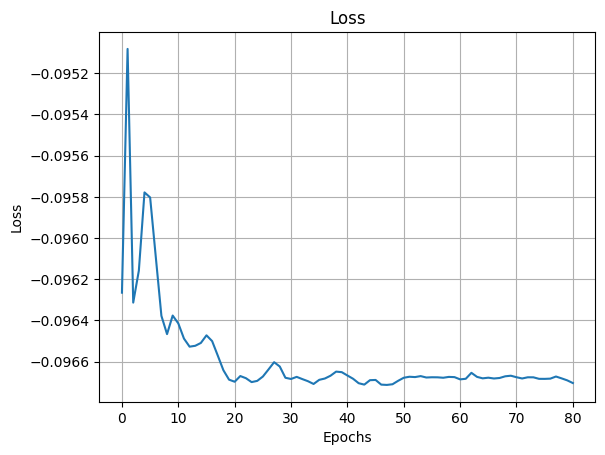

In [14]:
# Plot loss curve
epochs = range(n_epochs+1)

fig, ax = plt.subplots()
ax.plot(epochs, losses)

ax.set(xlabel='Epochs', ylabel='Loss',
       title='Loss')
ax.grid()
from google.colab import files
#fig.savefig("loss_correl{}_mu{}_sigma{}.png".format(rho,mu,np.diag(cov)), format='png', dpi=500)
#files.download("loss_correl{}_mu{}_sigma{}.png".format(rho,mu,np.diag(cov)))

plt.show()


In [19]:
# set up the test data set
# set up the seed
seed = 33
# set up the trading costs
all_cost = np.ones([num_stocks,seq_length-1,total_path])
for i in range(num_stocks):
  all_cost[i,:,:] = trade_cost[i]

# calculate rho: Notice the single is used only for plotting a 2 asset situation
if (num_stocks==2):
    rho = np.round(cov[0,1]/(np.sqrt(cov[0,0]*cov[1,1])),3)

# Create a stock simulation with prices, returns
stock = dg.ManyStocks(seed,num_stocks,mu,s0,cov,total_path,seq_length-1,T)
returns = torch.tensor(stock.Returns(),dtype=torch.float).to(device)

# Create a default strategy as initial input, better use the optimal strategy without cost
strategy = (torch.tensor(Markowitz_opt,dtype=torch.float).view(num_stocks,1,1)*torch.ones((num_stocks,seq_length,total_path),dtype=torch.float)).to(device)

# Create a trading cost
cost =  torch.tensor(all_cost,dtype=torch.float).to(device)
del all_cost

# A module for importance sampling
vol = np.sqrt(np.diag(np.diag(cov)))
h = (1-utility_gamma)/utility_gamma*np.matmul(vol,np.matmul(np.linalg.inv(cov),mu.reshape([num_stocks,1])))
BM_last = np.cumsum(stock.BM(),1)[:,-1,:]
mu_importance = np.matmul(vol,h).reshape([num_stocks])+mu
returns_importance = torch.tensor(dg.ManyStocks(seed,num_stocks,mu_importance.T,s0,cov,total_path,seq_length-1,T).Returns(),dtype=torch.float).to(device)
scaler_comp1 = -1/2*np.matmul(h.T,h)*T
scaler_comp2 = -h.reshape([num_stocks,1])*BM_last
scaler = torch.tensor(np.exp(np.sum(scaler_comp2,0)+scaler_comp1),dtype=torch.float).to(device)

In [17]:
# generate the output of test data
_, outputs = model(strategy.to(device),strategy[:,0,0], returns_importance, cost, None)
loss = criterion(outputs)+1/(1-utility_gamma)

rates = np.log(np.power((utility_gamma-1)*losses+1,1/(1-utility_gamma)))/T
epochs = range(n_epochs+1)

fig, ax = plt.subplots()
ax.plot(epochs, rates)

ax.set(xlabel='Epochs', ylabel='ESR',
       title='ESR')
ax.grid()
from google.colab import files
#fig.savefig("loss_correl{}_mu{}_sigma{}.png".format(rho,mu,np.diag(cov)), format='png', dpi=500)
#files.download("loss_correl{}_mu{}_sigma{}.png".format(rho,mu,np.diag(cov)))

plt.show()

<ipython-input-14-62e0e5d3b37f>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pi_bar = (torch.tensor(target,dtype=torch.float).to(device).view(self.dim_size,self.hidden_size,self.hidden_size)*\


NameError: name 'losses' is not defined

In [31]:
# an ESR module with testing data without cost
# the first is the etf and second is the simple no trade region, third is the merton optimal
LL = criterion(torch.pow(torch.prod(torch.sum(strategy[:, :-1, :] * returns, 0)+1,0),1-utility_gamma)/(1-utility_gamma))+1/(1-utility_gamma)
print(np.log(np.power((utility_gamma-1)*LL.detach().cpu().numpy()+1,1/(1-utility_gamma)))/T)
#print(np.matmul(mu.T,np.matmul(np.linalg.inv(cov),mu))/utility_gamma/2)
lower = strategy[:,0,:].view(num_stocks,1,npaths)-torch.pow(0.75/utility_gamma*(strategy*strategy*(1-strategy)*(1-strategy))[:,0,:].view(num_stocks,1,npaths)*cost[:,0,:].view(num_stocks,1,npaths),1/3)
upper = strategy[:,0,:].view(num_stocks,1,npaths)+torch.pow(0.75/utility_gamma*(strategy*strategy*(1-strategy)*(1-strategy))[:,0,:].view(num_stocks,1,npaths)*cost[:,0,:].view(num_stocks,1,npaths),1/3)

stra_NTR_the = simpleNTR(strategy, returns, upper, lower)
LL2 = criterion(torch.pow(torch.prod(torch.sum(stra_NTR_the[:, :-1, :] * returns, 0)+1,0),1-utility_gamma)/(1-utility_gamma))+1/(1-utility_gamma)
print(np.log(np.power((utility_gamma-1)*LL2.detach().cpu().numpy()+1,1/(1-utility_gamma)))/T)
print(np.matmul(mu.T,np.matmul(np.linalg.inv(cov),mu))/2/utility_gamma)

0.015902270849862336
0.015708172037953348
0.018000000000000002


In [38]:
1/T*torch.log(torch.pow(torch.mean(torch.pow(torch.prod(torch.sum(strategy[:, :-1, :] * returns_importance, 0)+1,0),1-utility_gamma)*scaler),1/(1-utility_gamma)))

tensor(0.0214, device='cuda:0')

In [39]:
1/T*torch.log(torch.pow(torch.mean(torch.pow(torch.prod(torch.sum(strategy[:, :-1, :] * returns, 0)+1,0),1-utility_gamma)),1/(1-utility_gamma)))

tensor(0.0164, device='cuda:0')

In [19]:
# an ESR module with testing data cost
# the first is the etf and second is the simple no trade region, third is the rnn model
print(torch.log(torch.pow(torch.mean(torch.pow(torch.prod(cal_return(strategy,returns,cost)+1,0),1-utility_gamma)),1/(1-utility_gamma)))/T)
print(torch.log(torch.pow(torch.mean(torch.pow(torch.prod(cal_return(stra_NTR_the,returns,cost)+1,0),1-utility_gamma)),1/(1-utility_gamma)))/T)
print(torch.log(torch.pow(torch.mean(torch.pow(torch.prod(cal_return(_,returns,cost)+1,0),1-utility_gamma)),1/(1-utility_gamma)))/T)

tensor(0.0114, device='cuda:0')
tensor(0.0151, device='cuda:0')
tensor(0.0150, device='cuda:0', grad_fn=<DivBackward0>)


In [18]:
print(torch.log(torch.pow(torch.mean(torch.pow(torch.prod(cal_return(_,returns,cost)+1,0),1-utility_gamma)),1/(1-utility_gamma)))/T)

tensor(0.0160, device='cuda:0', grad_fn=<DivBackward0>)


In [78]:
torch.pow(torch.prod(torch.sum(strategy[:, :-1, :] * returns_importance, 0)+1,0),1-utility_gamma)*scaler

tensor([[0.8205, 0.8220, 0.8307,  ..., 0.8152, 0.8082, 0.7985]],
       device='cuda:0')

In [77]:
1/T*torch.log(torch.pow(torch.mean(torch.pow(torch.prod(torch.sum(strategy[:, :-1, :] * returns, 0)+1,0),1-utility_gamma)),1/(1-utility_gamma)))

tensor(0.0164, device='cuda:0')

In [ ]:
# output the weights and bias of the model parameter and save them to memory
for name, param in model.named_parameters():
     print (name, param.data.size())

model_state_dict = model.state_dict()

rnn.edge_coef.weight torch.Size([11, 11])
rnn.edge_coef.bias torch.Size([11])
out.weight torch.Size([1, 11])


In [ ]:
import sys

def get_model_memory_usage(model):
    mem_usage_bytes = sum([param.element_size() * param.nelement() for param in model.parameters()])
    mem_usage_mb = mem_usage_bytes / (1024 ** 2)
    return mem_usage_mb

# Loop over all global variables
for name, value in list(globals().items()):
    # Ignore __builtins__ and modules, as they are not relevant here
    if not name.startswith("__") and not hasattr(value, "__name__"):
        # Check the size of the variable
        size_in_bytes = sys.getsizeof(value)
        size_in_mb = size_in_bytes / (1024 * 1024)
        if size_in_mb > 10:
            print(f"Variable '{name}' takes {size_in_mb} MB")
    if torch.is_tensor(value):
      size_in_bytes = value.element_size() * value.nelement()/(1024 ** 2)
      if size_in_bytes>10:
        print(f"Variable '{name}' takes {size_in_bytes} MB")


Variable '_' takes 124.8779296875 MB
Variable 'returns' takes 123.57711791992188 MB
Variable 'strategy' takes 124.8779296875 MB
Variable 'cost' takes 123.57711791992188 MB
Variable 'returns_importance' takes 123.57711791992188 MB


In [ ]:
# monthly return comparison
# apply the strategy to some existing real_world data with different rebalancing frequency
batches = 0
torch.cuda.empty_cache()
seq_length_new = 70
total_path_new = 2
npaths_new = 2
selector = np.random.randint(low=1,high=10000)
returns_real = returns[:,:,selector].view([num_stocks,seq_length_new-1,1])*torch.ones([num_stocks,seq_length_new-1,npaths_new]).to(device)
strategy = (torch.tensor(Markowitz_opt,dtype=torch.float).view(num_stocks,1,1)*torch.ones((num_stocks,seq_length_new,total_path_new),dtype=torch.float)).to(device)
all_cost = np.ones([num_stocks,seq_length_new-1,total_path_new])
for i in range(num_stocks):
  all_cost[i,:,:] = trade_cost[i]
cost =  torch.tensor(all_cost,dtype=torch.float).to(device)
del all_cost

cost2 = torch.zeros([num_stocks,seq_length_new-1,total_path_new]).to(device)

model2 = SimpleRNN(input_size, hidden_size, n_layers, npaths_new, seq_length_new,dim_size).to(device)
model2.load_state_dict(model_state_dict)
stra,  _= model2(strategy.to(device)[:,:,batches*npaths_new:(batches+1)*npaths_new],strategy.to(device)[:,0,0], returns_real[:,:,batches*npaths_new:(batches+1)*npaths_new],cost[:,:,batches*npaths_new:(batches+1)*npaths_new], None)
lower = strategy[:,0,:].view(num_stocks,1,npaths_new)-torch.pow(0.75/utility_gamma*(strategy*strategy*(1-strategy)*(1-strategy))[:,0,:].view(num_stocks,1,npaths_new)*cost[:,0,:].view(num_stocks,1,npaths_new),1/3)
upper = strategy[:,0,:].view(num_stocks,1,npaths_new)+torch.pow(0.75/utility_gamma*(strategy*strategy*(1-strategy)*(1-strategy))[:,0,:].view(num_stocks,1,npaths_new)*cost[:,0,:].view(num_stocks,1,npaths_new),1/3)
stra_NTR = simpleNTR(strategy, returns_real, upper, lower)

# creating relavent returns
ret_opt = cal_return(stra[:,:,0].view([num_stocks,seq_length_new,1]), returns_real[:,:,0].view([num_stocks,seq_length_new-1,1]),cost[:,:,0].view([num_stocks,seq_length_new-1,1]))
ret_target = cal_return(strategy[:,:,0].view([num_stocks,seq_length_new,1]), returns_real[:,:,0].view([num_stocks,seq_length_new-1,1]),cost2[:,:,0].view([num_stocks,seq_length_new-1,1]))
ret_simpleNTR = cal_return(stra_NTR[:,:,0].view([num_stocks,seq_length_new,1]), returns_real[:,:,0].view([num_stocks,seq_length_new-1,1]),cost[:,:,0].view([num_stocks,seq_length_new-1,1]))

# calculating tracking difference and error
TD_opt = 12*torch.mean(ret_opt-ret_target)
TD_NTR = 12*torch.mean(ret_simpleNTR-ret_target)
TE_opt = 12**0.5*torch.sqrt(torch.mean((ret_opt-ret_target-TD_opt/12)*(ret_opt-ret_target-TD_opt/12)))
TE_NTR = 12**0.5*torch.sqrt(torch.mean((ret_simpleNTR-ret_target-TD_NTR/12)*(ret_simpleNTR-ret_target-TD_NTR/12)))
tValue_opt = TD_opt/TE_opt*torch.sqrt(torch.tensor(seq_length_new-1).to(device))/np.sqrt(12)
tValue_NTR = TD_NTR/TE_NTR*torch.sqrt(torch.tensor(seq_length_new-1).to(device))/np.sqrt(12)
print(TD_opt)
print(TD_NTR)
print(TE_opt)
print(TE_NTR)
print(tValue_opt)
print(tValue_NTR)

In [ ]:
# remake the portfolio
start = '2009-08-01'
start1 = '2017-03-01'
start2 = '2019-03-01'
end = '2023-06-01'
tickers_dates = {"XLE":start, "XLF":start, "XLP":start, "XLV":start, "XLB":start, "XLK":start, "XLY":start, "XLI":start, "XLU":start, "XLRE":start1, "XLC":start2}
# initialize an empty dataframe to store data
dataframes = {}

# download data for each ticker
for ticker, start_time in tickers_dates.items():
    data = yf.download(ticker, start=start_time, progress=False,interval='1mo')
    # Save only the 'Adj Close' column
    dataframes[ticker] = data['Adj Close']

# Join all the dataframes into one
data_price = pd.concat(dataframes, axis=1)

In [ ]:
# monthly return comparison
# apply the strategy to some existing real_world data with different rebalancing frequency
batches = 0
torch.cuda.empty_cache()
seq_length_new = 166
total_path_new = 2
npaths_new = 2
break1 = 116
break2 = 92
#selector = np.random.randint(low=1,high=10000)
returns_real = torch.tensor(np.array(data_price.pct_change()[1:].fillna(0)[:seq_length_new-1]).T.reshape([num_stocks,seq_length_new-1,1])*np.ones([num_stocks,seq_length_new-1,npaths_new]),dtype=torch.float).to(device)
#returns_real = returns[:,:seq_length_new-1,selector].view([num_stocks,seq_length_new-1,1])*torch.ones([num_stocks,seq_length_new-1,npaths_new]).to(device)
strategy = (torch.tensor(Markowitz_opt,dtype=torch.float).view(num_stocks,1,1)*torch.ones((num_stocks,seq_length_new,total_path_new),dtype=torch.float)).to(device)
all_cost = np.ones([num_stocks,seq_length_new-1,total_path_new])
for i in range(num_stocks):
  all_cost[i,:,:] = trade_cost[i]
cost =  torch.tensor(all_cost,dtype=torch.float).to(device)
del all_cost

cost2 = torch.zeros([num_stocks,seq_length_new-1,total_path_new]).to(device)

model2 = SimpleRNN_No_Importance(input_size, hidden_size, n_layers, npaths_new, seq_length_new,dim_size).to(device)
model2.load_state_dict(model_state_dict)
stra,  _= model2(strategy.to(device)[:,:,batches*npaths_new:(batches+1)*npaths_new],strategy.to(device)[:,0,0], returns_real[:,:,batches*npaths_new:(batches+1)*npaths_new],cost[:,:,batches*npaths_new:(batches+1)*npaths_new], None)
lower = strategy[:,0,:].view(num_stocks,1,npaths_new)-torch.pow(0.75/utility_gamma*(strategy*strategy*(1-strategy)*(1-strategy))[:,0,:].view(num_stocks,1,npaths_new)*cost[:,0,:].view(num_stocks,1,npaths_new),1/3)
upper = strategy[:,0,:].view(num_stocks,1,npaths_new)+torch.pow(0.75/utility_gamma*(strategy*strategy*(1-strategy)*(1-strategy))[:,0,:].view(num_stocks,1,npaths_new)*cost[:,0,:].view(num_stocks,1,npaths_new),1/3)

stra_NTR = simpleNTR(strategy, returns_real, upper, lower)
stra = sliceLinear(sliceLinear(stra,break1,11,10),break2,10,9)
stra_NTR = sliceLinear(sliceLinear(stra_NTR,break1,11,10),break2,10,9)
strategy = sliceLinear(sliceLinear(strategy,break1,11,10),break2,10,9)

# creating relavent returns
ret_opt = cal_return(stra[:,:,0].view([num_stocks,seq_length_new,1]), returns_real[:,:,0].view([num_stocks,seq_length_new-1,1]),cost[:,:,0].view([num_stocks,seq_length_new-1,1]))
ret_target = cal_return(strategy[:,:,0].view([num_stocks,seq_length_new,1]), returns_real[:,:,0].view([num_stocks,seq_length_new-1,1]),cost2[:,:,0].view([num_stocks,seq_length_new-1,1]))
#ret_etf = torch.tensor(np.array(yf.download(etf,start,end,progress=False,interval='1mo')["Adj Close"].pct_change()[1:]+manage_fee/12)[:seq_length_new-1],dtype = torch.float).to(device).view([seq_length_new-1,1])
ret_etf = torch.tensor(np.array(yf.download(etf,start,end,progress=False,interval='1mo')["Adj Close"].pct_change()[1:])[:seq_length_new-1],dtype = torch.float).to(device).view([seq_length_new-1,1])
ret_simpleNTR = cal_return(stra_NTR[:,:,0].view([num_stocks,seq_length_new,1]), returns_real[:,:,0].view([num_stocks,seq_length_new-1,1]),cost[:,:,0].view([num_stocks,seq_length_new-1,1]))

# calculating tracking difference and error
TD_opt = 12*torch.mean(ret_opt-ret_target)
TD_etf = 12*torch.mean(ret_etf-ret_target)
TD_NTR = 12*torch.mean(ret_simpleNTR-ret_target)
TE_opt = 12**0.5*torch.sqrt(torch.mean((ret_opt-ret_target-TD_opt/12)*(ret_opt-ret_target-TD_opt/12)))
TE_etf = 12**0.5*torch.sqrt(torch.mean((ret_etf-ret_target-TD_etf/12)*(ret_etf-ret_target-TD_etf/12)))
TE_NTR = 12**0.5*torch.sqrt(torch.mean((ret_simpleNTR-ret_target-TD_NTR/12)*(ret_simpleNTR-ret_target-TD_NTR/12)))
tValue_opt = TD_opt/TE_opt*torch.sqrt(torch.tensor(seq_length_new-1).to(device))/np.sqrt(12)
tValue_etf = TD_etf/TE_etf*torch.sqrt(torch.tensor(seq_length_new-1).to(device))/np.sqrt(12)
tValue_NTR = TD_NTR/TE_NTR*torch.sqrt(torch.tensor(seq_length_new-1).to(device))/np.sqrt(12)
print(TD_opt)
print(TD_etf)
print(TD_NTR)
print(TE_opt)
print(TE_etf)
print(TE_NTR)
print(tValue_opt)
print(tValue_etf)
print(tValue_NTR)

<ipython-input-12-62e0e5d3b37f>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pi_bar = (torch.tensor(target,dtype=torch.float).to(device).view(self.dim_size,self.hidden_size,self.hidden_size)*\


tensor(0.0066, device='cuda:0', grad_fn=<MulBackward0>)
tensor(-0.0039, device='cuda:0')
tensor(0.0055, device='cuda:0')
tensor(0.0179, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0120, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(1.3646, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-1.2168, device='cuda:0')
tensor(2.0067, device='cuda:0')


In [ ]:
print(torch.prod(ret_opt+1))
print(torch.prod(ret_target+1))
print(torch.prod(ret_etf+1))
print(torch.prod(ret_simpleNTR+1))

tensor(4.7895, device='cuda:0', grad_fn=<ProdBackward0>)
tensor(4.7872, device='cuda:0')
tensor(4.5601, device='cuda:0')
tensor(5.0659, device='cuda:0')


In [ ]:
# quarterly return comparison
# apply the strategy to some existing real_world data with different rebalancing frequency
batches = 0
torch.cuda.empty_cache()
seq_length_new = 29
total_path_new = 2
npaths_new = 2
returns_real = torch.tensor(np.array(yf.download(tickers,start,end,progress=False,interval='1mo')["Adj Close"].resample('Q').last().pct_change()[1:][:seq_length_new-1]).T.reshape([num_stocks,seq_length_new-1,1])*np.ones([num_stocks,seq_length_new-1,npaths_new]),dtype=torch.float).to(device)


strategy = (torch.tensor(Markowitz_opt,dtype=torch.float).view(num_stocks,1,1)*torch.ones((num_stocks,seq_length_new,total_path_new),dtype=torch.float)).to(device)
all_cost = np.ones([num_stocks,seq_length_new-1,total_path_new])
for i in range(num_stocks):
  all_cost[i,:,:] = trade_cost[i]
cost =  torch.tensor(all_cost,dtype=torch.float).to(device)
cost2 = torch.zeros([num_stocks,seq_length_new-1,total_path_new]).to(device)
del all_cost
model2 = SimpleRNN(input_size, hidden_size, n_layers, npaths_new, seq_length_new,dim_size).to(device)
model2.load_state_dict(model_state_dict)
stra, _= model2(strategy.to(device)[:,:,batches*npaths_new:(batches+1)*npaths_new], strategy.to(device)[:,0,0],returns_real[:,:,batches*npaths_new:(batches+1)*npaths_new],cost[:,:,batches*npaths_new:(batches+1)*npaths_new], None)
lower = strategy[:,0,:].view(num_stocks,1,npaths_new)-torch.pow(0.75/utility_gamma*(strategy*strategy*(1-strategy)*(1-strategy))[:,0,:].view(num_stocks,1,npaths_new)*cost[:,0,:].view(num_stocks,1,npaths_new),1/3)
upper = strategy[:,0,:].view(num_stocks,1,npaths_new)+torch.pow(0.75/utility_gamma*(strategy*strategy*(1-strategy)*(1-strategy))[:,0,:].view(num_stocks,1,npaths_new)*cost[:,0,:].view(num_stocks,1,npaths_new),1/3)
stra_NTR = simpleNTR(strategy, returns_real, upper, lower)

# creating relavent returns
ret_opt = cal_return(stra[:,:,0].view([num_stocks,seq_length_new,1]), returns_real[:,:,0].view([num_stocks,seq_length_new-1,1]),cost[:,:,0].view([num_stocks,seq_length_new-1,1]))
ret_target = cal_return(strategy[:,:,0].view([num_stocks,seq_length_new,1]), returns_real[:,:,0].view([num_stocks,seq_length_new-1,1]),cost2[:,:,0].view([num_stocks,seq_length_new-1,1]))
#ret_etf = torch.tensor(np.array(yf.download(etf,start,end,progress=False,interval='1mo')["Adj Close"].resample('Q').last().pct_change()[1:]+manage_fee/4)[:seq_length_new-1],dtype = torch.float).to(device).view([seq_length_new-1,1])
ret_etf = torch.tensor(np.array(yf.download(etf,start,end,progress=False,interval='1mo')["Adj Close"].resample('Q').last().pct_change()[1:])[:seq_length_new-1],dtype = torch.float).to(device).view([seq_length_new-1,1])
ret_simpleNTR = cal_return(stra_NTR[:,:,0].view([num_stocks,seq_length_new,1]), returns_real[:,:,0].view([num_stocks,seq_length_new-1,1]),cost[:,:,0].view([num_stocks,seq_length_new-1,1]))

# calculating tracking difference and error
TD_opt = 4*torch.mean(ret_opt-ret_target)
TD_etf = 4*torch.mean(ret_etf-ret_target)
TD_NTR = 4*torch.mean(ret_simpleNTR-ret_target)
TE_opt = 4**0.5*torch.sqrt(torch.mean((ret_opt-ret_target-TD_opt/4)*(ret_opt-ret_target-TD_opt/4)))
TE_etf = 4**0.5*torch.sqrt(torch.mean((ret_etf-ret_target-TD_etf/4)*(ret_etf-ret_target-TD_etf/4)))
TE_NTR = 4**0.5*torch.sqrt(torch.mean((ret_simpleNTR-ret_target-TD_NTR/4)*(ret_simpleNTR-ret_target-TD_NTR/4)))
tValue_opt = TD_opt/TE_opt*torch.sqrt(torch.tensor(seq_length_new-1).to(device))/np.sqrt(4)
tValue_etf = TD_etf/TE_etf*torch.sqrt(torch.tensor(seq_length_new-1).to(device))/np.sqrt(4)
tValue_NTR = TD_NTR/TE_NTR*torch.sqrt(torch.tensor(seq_length_new-1).to(device))/np.sqrt(4)
print(TD_opt)
print(TD_etf)
print(TD_NTR)
print(TE_opt)
print(TE_etf)
print(TE_NTR)
print(tValue_opt)
print(tValue_etf)
print(tValue_NTR)


<ipython-input-10-62e0e5d3b37f>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pi_bar = (torch.tensor(target,dtype=torch.float).to(device).view(self.dim_size,self.hidden_size,self.hidden_size)*\


tensor(-0.0005, device='cuda:0', grad_fn=<MulBackward0>)
tensor(-0.0051, device='cuda:0')
tensor(-0.0001, device='cuda:0')
tensor(0.0047, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0095, device='cuda:0')
tensor(0.0031, device='cuda:0')
tensor(-0.2602, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-1.4039, device='cuda:0')
tensor(-0.1091, device='cuda:0')


In [ ]:
# daily return comparison
# apply the strategy to some existing real_world data with different rebalancing frequency
batches = 0
if 'returns' in globals():
    del returns
torch.cuda.empty_cache()
seq_length_new = 1784
total_path_new = 2
npaths_new = 2
returns_real = torch.tensor(np.array(my_portfolio.assetsReturn())[:seq_length_new-1,:].T.reshape([num_stocks,seq_length_new-1,1])*np.ones([num_stocks,seq_length_new-1,npaths_new]),dtype=torch.float).to(device)

strategy = (torch.tensor(Markowitz_opt,dtype=torch.float).view(num_stocks,1,1)*torch.ones((num_stocks,seq_length_new,total_path_new),dtype=torch.float)).to(device)
all_cost = np.ones([num_stocks,seq_length_new-1,total_path_new])
for i in range(num_stocks):
  all_cost[i,:,:] = trade_cost[i]
cost =  torch.tensor(all_cost,dtype=torch.float).to(device)
cost2 = torch.zeros([num_stocks,seq_length_new-1,total_path_new]).to(device)
del all_cost
model2 = SimpleRNN(input_size, hidden_size, n_layers, npaths_new, seq_length_new,dim_size).to(device)
model2.load_state_dict(model_state_dict)

stra,  _ = model2(strategy.to(device)[:,:,batches*npaths_new:(batches+1)*npaths_new], strategy.to(device)[:,0,0],returns_real[:,:,batches*npaths_new:(batches+1)*npaths_new],cost[:,:,batches*npaths_new:(batches+1)*npaths_new], None)
lower = strategy[:,0,:].view(num_stocks,1,npaths_new)-torch.pow(0.75/utility_gamma*(strategy*strategy*(1-strategy)*(1-strategy))[:,0,:].view(num_stocks,1,npaths_new)*cost[:,0,:].view(num_stocks,1,npaths_new),1/3)
upper = strategy[:,0,:].view(num_stocks,1,npaths_new)+torch.pow(0.75/utility_gamma*(strategy*strategy*(1-strategy)*(1-strategy))[:,0,:].view(num_stocks,1,npaths_new)*cost[:,0,:].view(num_stocks,1,npaths_new),1/3)
stra_NTR = simpleNTR(strategy, returns_real, upper, lower)

# creating relavent returns
ret_opt = cal_return(stra[:,:,0].view([num_stocks,seq_length_new,1]), returns_real[:,:,0].view([num_stocks,seq_length_new-1,1]),cost[:,:,0].view([num_stocks,seq_length_new-1,1]))
ret_target = cal_return(strategy[:,:,0].view([num_stocks,seq_length_new,1]), returns_real[:,:,0].view([num_stocks,seq_length_new-1,1]),cost2[:,:,0].view([num_stocks,seq_length_new-1,1]))
#ret_etf = torch.tensor(np.array(yf.download(etf,start,end,progress=False,interval='1d')["Adj Close"].pct_change()[1:]+manage_fee/252)[:seq_length_new-1],dtype = torch.float).to(device).view([seq_length_new-1,1])
ret_etf = torch.tensor(np.array(yf.download(etf,start,end,progress=False,interval='1d')["Adj Close"].pct_change()[1:])[:seq_length_new-1],dtype = torch.float).to(device).view([seq_length_new-1,1])
ret_simpleNTR = cal_return(stra_NTR[:,:,0].view([num_stocks,seq_length_new,1]), returns_real[:,:,0].view([num_stocks,seq_length_new-1,1]),cost[:,:,0].view([num_stocks,seq_length_new-1,1]))

# calculating tracking difference and error
TD_opt = 252*torch.mean(ret_opt-ret_target)
TD_etf = 252*torch.mean(ret_etf-ret_target)
TD_NTR = 252*torch.mean(ret_simpleNTR-ret_target)
TE_opt = 252**0.5*torch.sqrt(torch.mean((ret_opt-ret_target-TD_opt/252)*(ret_opt-ret_target-TD_opt/252)))
TE_etf = 252**0.5*torch.sqrt(torch.mean((ret_etf-ret_target-TD_etf/252)*(ret_etf-ret_target-TD_etf/252)))
TE_NTR = 252**0.5*torch.sqrt(torch.mean((ret_simpleNTR-ret_target-TD_NTR/4)*(ret_simpleNTR-ret_target-TD_NTR/252)))
tValue_opt = TD_opt/TE_opt*torch.sqrt(torch.tensor(seq_length_new-1).to(device))/np.sqrt(252)
tValue_etf = TD_etf/TE_etf*torch.sqrt(torch.tensor(seq_length_new-1).to(device))/np.sqrt(252)
tValue_NTR = TD_NTR/TE_NTR*torch.sqrt(torch.tensor(seq_length_new-1).to(device))/np.sqrt(252)
print(TD_opt)
print(TD_etf)
print(TD_NTR)
print(TE_opt)
print(TE_etf)
print(TE_NTR)
print(tValue_opt)
print(tValue_etf)
print(tValue_NTR)

<ipython-input-10-62e0e5d3b37f>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pi_bar = (torch.tensor(target,dtype=torch.float).to(device).view(self.dim_size,self.hidden_size,self.hidden_size)*\


tensor(-0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(-0.0050, device='cuda:0')
tensor(-0.0004, device='cuda:0')
tensor(0.0041, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0450, device='cuda:0')
tensor(0.0035, device='cuda:0')
tensor(-1.4487, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.2975, device='cuda:0')
tensor(-0.2688, device='cuda:0')


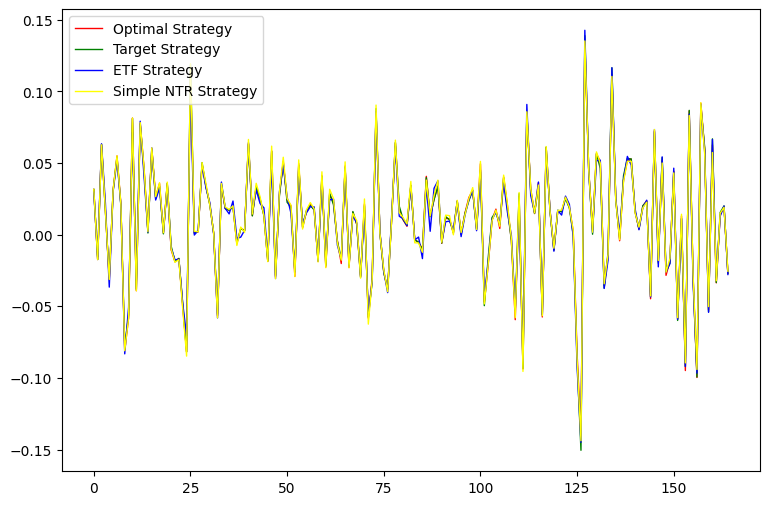

In [ ]:
plt.figure(figsize=(9,6))

# Plot each vector
plt.plot(ret_opt.cpu().detach().numpy(), label='Optimal Strategy', color='red',linewidth=1)
plt.plot(ret_target.cpu().detach().numpy(), label='Target Strategy', color='green',linewidth=1)
plt.plot(ret_etf.cpu().detach().numpy(), label='ETF Strategy', color='blue',linewidth=1)
plt.plot(ret_simpleNTR.cpu().detach().numpy(), label='Simple NTR Strategy', color='yellow',linewidth=1)
# Optionally add a legend
plt.legend(loc='upper left')

# Show the plot
plt.show()

<ipython-input-10-62e0e5d3b37f>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pi_bar = (torch.tensor(target,dtype=torch.float).to(device).view(self.dim_size,self.hidden_size,self.hidden_size)*\


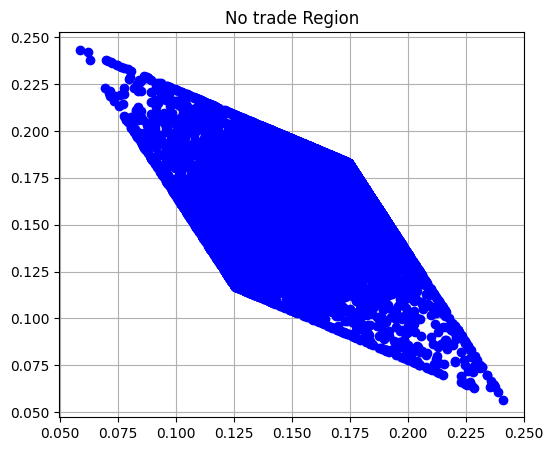

In [19]:
# Plain plot of 2 chosen dimensions of assets
ex_strategy = 3*torch.rand([num_stocks,seq_length,npaths]).to(device).view([num_stocks,seq_length,npaths])
o = model(ex_strategy, strategy[:,0,0], returns_importance, cost)[0]
x = o.cpu().detach().numpy()[0,7,:].reshape([1,npaths])
y = o.cpu().detach().numpy()[1,7,:].reshape([1,npaths])
#z = o.cpu().detach().numpy()[2,7,:].reshape([1,npaths])
plt.figure(figsize=(6,5))
#plt.xlim((0.05,0.25))
#plt.ylim((0.05,0.25))
#plt.xticks(np.arange(0.05,0.25,0.05))
#plt.yticks(np.arange(0.05,0.25,0.05))
plt.grid()
plt.title(label='No trade Region')
plt.plot(x, y, 'o', color='blue')
#plt.savefig("mu{}_sigmasquare{}.png".format(mu,np.diag(cov)), format='png', dpi=500)
#files.download("mu{}_sigmasquare{}.png".format(mu,np.diag(cov)))
plt.show()

In [ ]:
del ex_strategy
del o
torch.cuda.empty_cache()

In [ ]:
# Comparison between different ESR, notice this is specially defined for the liquid and illiquid case
# Calculate the simulated ESR
ESR_Simulation = torch.log(torch.pow(torch.mean(torch.pow(outputs,1-utility_gamma)),1/(1-utility_gamma)))/T
# Calculate the rho matrix
rho_matrix = cov/np.sqrt(np.diag(cov))/((np.sqrt(np.diag(cov))).T)
# Creating beta alpha and sigma_I
beta = np.zeros([num_stocks,num_stocks-1])
sigma_I = np.zeros([num_stocks,1])
lambda_I = np.zeros([num_stocks,1])
pi_bar = np.zeros([num_stocks,1])
reduction = np.zeros([num_stocks,1])
for s in range(num_stocks):
  sigma_temp = np.delete(np.delete(cov,s,0),s,1)
  vec_temp = np.delete(cov,s,0)[:,s]
  rho_s = np.matmul(np.matmul(vec_temp,np.linalg.inv(sigma_temp)),vec_temp)/cov[s,s]
  beta[s,:] = np.matmul(np.linalg.inv(sigma_temp),vec_temp)
  sigma_I[s] = cov[s,s]*(1-rho_s)
  pi_bar[s] = (mu[s]-np.matmul(beta[s,:],np.delete(mu,s,0).T))/(sigma_I[s]*utility_gamma)
  lambda_I[s] = np.power((0.75*utility_gamma*utility_gamma*pi_bar[s]*pi_bar[s]*sigma_I[s]*sigma_I[s]*\
(np.matmul(np.matmul((vec_temp-np.delete(mu/utility_gamma,s,0)).T,np.linalg.inv(sigma_temp)),(vec_temp-np.delete(mu/utility_gamma,s,0)))+(1-pi_bar[s])*(1-pi_bar[s])*sigma_I[s]))*trade_cost[s],1/3)
  reduction[s] = np.power(lambda_I[s],2)/(2*sigma_I[s]*utility_gamma)
ESR_Theo_max = np.matmul(np.matmul(mu.T,np.linalg.inv(cov)),mu)/2/utility_gamma-np.max(reduction)
ESR_Theo_min = np.matmul(np.matmul(mu.T,np.linalg.inv(cov)),mu)/2/utility_gamma-np.sum(reduction)
print(ESR_Simulation)
print(ESR_Theo_max)
print(ESR_Theo_min)

tensor(0.1411, device='cuda:0', grad_fn=<DivBackward0>)
0.13832101878296396
0.13779389918822954


In [ ]:
# Plot of rotating gif figure of 3-d assets
ex_strategy = torch.rand([num_stocks,seq_length,npaths]).to(device).view([num_stocks,seq_length,npaths])
o = model(ex_strategy)[0]
fig = plt.figure()
ax = Axes3D(fig)
x = o.cpu().detach().numpy()[4,10,:].reshape([1,npaths])
y = o.cpu().detach().numpy()[7,10,:].reshape([1,npaths])
z = o.cpu().detach().numpy()[2,10,:].reshape([1,npaths])

#ax.scatter(x, y, z, marker='.',color='blue');
def init():
    ax.scatter(x, y, z, marker='.', s=20, c="blue", alpha=0.6)
    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=180, interval=20, blit=True,repeat = True)


writer = animation.PillowWriter(fps=15,metadata=dict(artist='Me'),bitrate=900)
anim.save('scatter.gif', writer=writer)
files.download('scatter.gif');

In [ ]:
delta_real = np.power((3/4/utility_gamma*Markowitz_opt[0]*Markowitz_opt[0]*((1-Markowitz_opt[0])*(1-Markowitz_opt[0])+np.matmul(np.matmul(mu,np.linalg.inv(cov)),mu)/cov[0,0]))*trade_cost[0],1/3)
print(Markowitz_opt[0]+delta_real)
print(Markowitz_opt[0]-delta_real)
print(delta_tensor)
print(delta_real)

0.5838135623129366
0.16618643768706345
tensor([0.1329, 0.0666, 0.0983, 0.0926, 0.0997, 0.0805, 0.0960, 0.1117, 0.1027,
        0.1040, 0.1461, 0.1105, 0.1029, 0.1121, 0.0882, 0.0887, 0.0770, 0.0785,
        0.0992, 0.0894, 0.0783, 0.0682, 0.1023, 0.0830, 0.0936, 0.0656, 0.0773,
        0.0993, 0.0844, 0.1137], device='cuda:0')
0.20881356231293655


In [ ]:
print(o[:,4:,:].min())
print(o[:,4:,:].max())

tensor(0.0998, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.6832, device='cuda:0', grad_fn=<MaxBackward1>)
